In [75]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
attributesInput = pd.read_csv('../inputdata/AttributesF.csv')
emailDataInput = pd.read_csv('../inputdata/FinalEdata.csv')
conflictsInput = pd.read_csv('../inputdata/TC2.csv')

/tmp/ipykernel_1326/2872392612.py:7: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  emailDataInput = pd.read_csv('../inputdata/FinalEdata.csv')


In [76]:
relationships = conflictsInput.set_index(['Source'])
relationships = relationships.stack().to_frame()
relationships = relationships.rename_axis(['src', 'dest']).reset_index()
relationships = relationships.rename(columns={0: 'type'}) 
relationships = relationships.astype({'type': 'int32'})
relationships = relationships.astype({'dest': 'int32'})

In [77]:
relationships['num_emails'] = 0
relationships['workaround'] = 0

In [78]:
for i, row in relationships.iterrows():
    number_of_emails = len(emailDataInput.loc[(emailDataInput['Sender'] == row['src']) & (emailDataInput['Recipient'] == row['dest'])].index)
    if number_of_emails > 0:
        relationships.at[i, 'num_emails'] = number_of_emails

In [79]:
print("Relationships with at least 1 Email between them:", len(relationships.loc[relationships['num_emails']>0].index))
print("Relationships:", len(relationships.index))

Relationships with at least 1 Email between them: 1717
Relationships: 3586


In [80]:
conflicts = relationships.loc[relationships['type'] == 1]
for i, row in conflicts.iterrows():
    src_relationships = relationships.loc[(relationships['src'] == row['src']) | (relationships['dest'] == row['src'])]
    src_relationships = src_relationships.loc[src_relationships['type'] != 1]
    dest_relationships = relationships.loc[(relationships['src'] == row['dest']) | (relationships['dest'] == row['dest'])]
    dest_relationships = dest_relationships.loc[dest_relationships['type'] != 1]
    common_src = src_relationships.loc[(src_relationships['src'].isin(dest_relationships['src'])) | (src_relationships['dest'].isin(dest_relationships['src'])) | (src_relationships['src'].isin(dest_relationships['dest'])) | (src_relationships['dest'].isin(dest_relationships['dest']))]
    common_dest = dest_relationships.loc[(dest_relationships['src'].isin(src_relationships['src'])) | (dest_relationships['dest'].isin(src_relationships['src'])) | (dest_relationships['src'].isin(src_relationships['dest'])) | (dest_relationships['dest'].isin(src_relationships['dest']))]
    for j, src_row in common_src.iterrows():
        relationships.at[j, 'workaround'] = 1
    for j, dest_row in common_dest.iterrows():
        relationships.at[j, 'workaround'] = 1

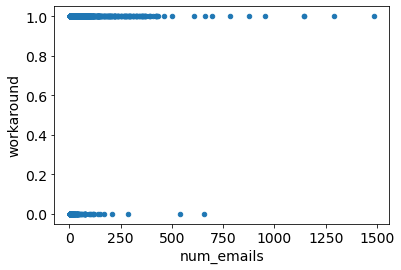

In [81]:
relationships = relationships.loc[relationships['num_emails'] > 0]
ax = relationships.plot.scatter(x='num_emails', y='workaround')
plt.show()

In [82]:
plt.rc("font", size=14)

In [83]:
X = relationships['num_emails']
y = relationships['workaround']
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.534423
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.461   
Dependent Variable: workaround       AIC:              1837.2070
Date:               2022-08-01 14:29 BIC:              1842.6554
No. Observations:   1717             Log-Likelihood:   -917.60  
Df Model:           0                LL-Null:          -627.94  
Df Residuals:       1716             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
-----------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
num_emails      0.0384    0.0027  14.0451  0.0000  0.0331  0.0438



In [84]:
relationships['conflict_present'] = np.where(relationships['type'] == 1, 1, 0)


In [85]:
X = relationships['num_emails']
y = relationships['conflict_present']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.498418
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.544   
Dependent Variable: conflict_present AIC:              1713.5667
Date:               2022-08-01 14:29 BIC:              1719.0150
No. Observations:   1717             Log-Likelihood:   -855.78  
Df Model:           0                LL-Null:          -554.42  
Df Residuals:       1716             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
num_emails  -0.0518    0.0035  -14.7117  0.0000  -0.0587  -0.0449

